In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os   
import statistics as stat
import skfmm
import scipy.integrate as integrate
import pandas as pd
import csv
from sklearn import linear_model

def hist(array,xmin,xmax,log,cumul,bins,weights,xlabel,title):
    plt.figure(figsize=(8,6))
    cs = plt.hist(array, alpha = 0.2, color = 'red', edgecolor = 'black', bins=bins, range = [xmin,xmax], weights = weights, log = log, cumulative = cumul)
    plt.title(title)
    plt.xlabel(xlabel); plt.ylabel('Frequency')    
    plt.show()
    return

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
   
def colorplot(arr, path):
    fig = plt.figure(figsize=(10, 8))
    
    ax = fig.add_subplot(221)
    ax.set_title('colorMap')
    im = ax.imshow(arr)
    ax.set_aspect('equal')

    ax2 = fig.add_subplot(222)
    img=mpimg.imread(path)
    imgplot = ax2.imshow(img)
    
    cax = fig.add_axes([0.45, 0.535, 0.03, 0.35])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(True)
    cax.set_ylabel("Time '(s)' ")
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    cbar = plt.colorbar(im, cax = cax, orientation='vertical')
    cbar.set_label('Time', rotation=270, labelpad=20)
    return plt.show()
    
    
    
def centerpoint(arr):
    import math
    x = arr.shape[0]
    y = arr.shape[1]
    
    if x % 2:
        x = math.floor(x/2)
    else:
        x = int(x/2)
    if y % 2:
        y = math.floor(y/2) 
    else:
        y = int(y/2)
    return x,y 

def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        print("2d")
        ny = (array.shape[0])
        nx = (array.shape[1])
        print(str(nx) + 'x' + str(ny))
    
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')
            
    elif array.ndim == 1:
        print('1d')
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()

    
def vargplt(lag,gamma,npair,vtype,name,xmin,xmax,ymin,ymax,sill,title,cmap):
    plt.figure(figsize=(8,6))
    marker = ["o","v","s","h","^",">","<"]
    im = 0
    if type(lag)==type(list()):
        if vtype==0:
            im = plt.scatter(lag,gamma,s=None, c=npair, marker=None, label = name,cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
        else:
            plt.plot(lag,gamma,'C3',lw=3,c='black')
    else:
        nvar = lag.shape[0]
        for ivar in range(0, nvar):
            if vtype[ivar]==0:
                im = plt.scatter(lag[ivar],gamma[ivar],s=None,label = name[ivar],c=npair[ivar], marker=marker[ivar], cmap=cmap, norm=None, alpha=0.8, linewidths=0.8, verts=None, edgecolors="black")
            else:
                plt.plot(lag[ivar],gamma[ivar], 'C3', lw=3,c='black')
    ixy = 0 
    plt.title(title)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)    
    plt.xlabel('Lag Distance (pixels)')
    plt.ylabel('Variogram')
    plt.arrow(0,sill,xmax,0,width=0.002,color='red',head_length=0.0,head_width=0.0)
    plt.legend(loc = 'lower right')
    if im != 0:
        cbar = plt.colorbar(im, orientation = 'vertical')
        cbar.set_label('Number of Pairs', rotation=270, labelpad=20)
    plt.show()
    return im
def vmodel_2d(nlag,step,azi,nug,nst,tstr1,c1,azi1,rmaj1,rmin1,tstr2=1,c2=0,azi2=0,rmaj2=0,rmin2=0):
    import os
    import numpy as np

    lag = []; gamma = []
    
    file = open("vmodel.par", "w")
    file.write("                                                                           \n")
    file.write("                  Parameters for VMODEL                                    \n")
    file.write("                  *********************                                    \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("vmodel.var                   -file for variogram output                    \n")
    file.write("1 " + str(nlag) + "          -number of directions and lags                \n")
    file.write(str(azi) + " 0.0 " + str(step) + " -azm, dip, lag distance                  \n")
    file.write(str(nst) + " " + str(nug) + " -nst, nugget effect                           \n")
    file.write(str(tstr1) + " " + str(c1) + " " + str(azi1) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj1) + " " + str(rmin1) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.write(str(tstr2) + " " + str(c2) + " " + str(azi2) + " 0.0   0.0   0.0 -it,cc,ang1,ang2,ang3 \n")
    file.write(str(rmaj2) + " " + str(rmin2) + " 0.0 -a_hmax, a_hmin, a_vert               \n")
    file.close()
    
    os.system('vmodel.exe vmodel.par')
    reading = True
    with open("vmodel.var") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma)                

def gam_2d(array,nx,ny,hsiz,nlag,xlag,ylag,bstand):
    import os
    import numpy as np
    
    lag = []; gamma = []; npair = []
    
    ndarray2GSLIB(array,"gam_out.dat","gam.dat")
    
    file = open("gam.par", "w")
    file.write("                  Parameters for GAM                                       \n")
    file.write("                  ******************                                       \n")
    file.write("                                                                           \n")
    file.write("START OF PARAMETERS:                                                       \n")
    file.write("gam_out.dat           -file with data                                      \n")
    file.write("1   1   0             -   number of variables, column numbers              \n")
    file.write("-1.0e21     1.0e21    -   trimming limits                                  \n")
    file.write("gam.out               -file for variogram output                           \n")
    file.write("1                     -grid or realization number                          \n")
    file.write(str(nx) + " 0.0 " + str(hsiz) + "  -nx, xmn, xsiz                           \n")
    file.write(str(ny) + " 0.0 " + str(hsiz) + "  -ny, ymn, ysiz                           \n")
    file.write(" 1   0.5   1.0        -nz, zmn, zsiz                                       \n")
    file.write("1 " + str(nlag) + "   -number of directions, number of lags                \n")
    file.write(str(xlag) + " " + str(ylag) + " 0 -ixd(1),iyd(1),izd(1)                     \n")
    file.write("1                     -standardize sill? (0=no, 1=yes)                     \n")
    file.write("1                     -number of variograms                                \n")
    file.write("1   1   1             -tail variable, head variable, variogram type        \n") 
    file.close()
    
    os.system('gam.exe gam.par')
    reading = True
    with open("gam.out") as myfile:   
        head = [next(myfile) for x in range(1)] # skip the first line
        iline = 0
        while reading:
            try:
                head = [next(myfile) for x in range(1)]
                lag.append(float(head[0].split()[1]))
                gamma.append(float(head[0].split()[2]))
                npair.append(float(head[0].split()[3]))
                iline = iline + 1
            except StopIteration:
                reading = False   
    
    return(lag,gamma,npair)  
            
    
def image_convert(file):
    answer = input("Type 'd' for distance plot, 'c' for colorplot, 'v' for variogram, 'm' for vmodel, 'a' for area, 'f' for full data analysis: ")
    if 'd' in answer:
        a1 = True
    else:
        a1 = False
    
    if 'c' in answer:
        a2 = True   
    else: 
        a2 = False
    if 'v' in answer:
        a3 = True   
    else: 
        a3 = False
    if 'm' in answer:
        a4 = True   
    else: 
        a4 = False
    if 'a' in answer:
        a5 = True   
    else: 
        a5 = False
        
    if 'f' in answer:
        a6 = True   
    else: 
        a6 = False
    
    if (a1 == False) & (a2 == False) & (a3 == False) & (a4 == False) & (a5 == False) & (a6 == False):
        print('User did not enter a valid entry---> Exiting...')
        return
    
    integrals = []                                              #declare lists for appending img values
    file_num = []
    range_x, range_y = [], []
    nug = []
    
    
    
    files = 1
    for image_path in os.listdir(file):
        input_path = os.path.join(file, image_path)
        img = mpimg.imread(input_path)     
        gray = rgb2gray(img)
        xdim, ydim = gray.shape
        print("working..." + image_path)
        
        file_num.append(files)
        files += 1
        
        if np.where(gray > 1):
            gray = np.divide(gray,255)
        gray_min = np.amin(gray)
        gray_max = np.amax(gray)
        z = []
        tmean = 0.5
        for ix in np.nditer(gray):
            z.append((ix - gray_min) + tmean)
        gray_arr = np.asarray(z).reshape(xdim,ydim)         # get the grayscale array with the same dimensions as image
        
            
        fmm(gray_arr,a1,a2,a3,a4,a5,a6,integrals, file_num, range_x, range_y, nug, input_path,file)                                 # input data for getting plots
        
    return 
    

def fmm(array,a1,a2,a3,a4,a5,a6,integrals, file_num, range_x, range_y, nug, path,file):
     
    ydim, xdim = array.shape
    xx,yy = centerpoint(array)    
    
    if a1 or a2 or a6 or a5:
        var_arr = []; avg_arr = []; dist_arr = []; a = 0; b = 0;  
        phi = np.ones_like(array)
        phi[xx,yy] = -1 
        speed = np.ones_like(array)
        speed[array>.7] = 10

        d = skfmm.distance(phi, dx =1)                                        #used to get the indices for cacluating radiuses 
        t = skfmm.travel_time(phi, speed, dx =1) 
        R = d[a,b]; r = d[a,b]-1

        while R > 0:                                           #loops through all radiuses 
            iix = t[np.where(np.logical_and(d>=r, d<=R))]
            var_arr.append(float(np.var(iix)))
            avg_arr.append(float(np.average(iix)))
            R = d[a,b]
            r = d[a,b]-1
            dist = d[np.where(np.logical_and(d>=r, d<=R))]
            dist_arr.append(float(np.average(dist)))

            if a < xx:
                a +=1
            else:
                b +=1
    
    if a1:
        xmin = 0; xmax = round(max(dist_arr))
        lin_plt(x_arr = dist_arr, y_arr = var_arr, xmin =xmin, xmax = xmax, 
                step = 75, xlab = "Distance", ylab = 'Variance', title = "Distance Vs. Variance", color ='r', path = path)
    if a2:
        colorplot(t, path)
    if a3 or a4 or a6:
        nx = xdim
        ny = ydim
        
        cell_size = 1.0
        nlag = xdim; standardize = 0                                       # set the variogram parameters
        xlag = 1; ylag = 0;   # calculate the variograms in the x and y direction
        lag_x,gamma_x,npair_x = gam_2d(array,nx,ny,cell_size,nlag,xlag,ylag,standardize)
        xlag = 0; ylag = 1;
        nlag = ydim
        lag_y,gamma_y,npair_y = gam_2d(array,nx,ny,cell_size,nlag,xlag,ylag,standardize)
        nugx = gamma_x[0]; nugy = gamma_y[0]
        
        
        if nugx > nugy:
            nug.append(nugy)
        else:
            nug.append(nugx)
            
        ranx = 0; rany = 0
        for i in gamma_x:
            if i >= 1.0:
                range_x.append(lag_x[gamma_x.index(i)])
                ranx +=1
                break
        if ranx ==0:
            range_x.append(lag_x[gamma_x.index(max(gamma_x))])
            
               
        for i in gamma_y:
            if i >= 1.0:
                range_y.append(lag_y[gamma_y.index(i)])
                rany +=1
                break
        if rany ==0:
            range_y.append(lag_y[gamma_y.index(max(gamma_y))])
            
                
        
        if a3 or a4:
            lags = np.array([lag_x,lag_y])                                   # combine into in lists of arrays to pass to plotting
            gammas = np.array([gamma_x,gamma_y])
            npairs = np.array([npair_x,npair_y])
            vtypes = [0,0]
            names = ['Azi 090','Azi 000']
            cmap = plt.cm.plasma
        

        if a3:
            vargplt(lags,gammas,npairs,vtypes,names,0,1500,0,1.2,1,"Variogram",cmap)
            
        
        if a4:
            lag_maxx= lag_x[gamma_x.index(max(gamma_x))]
            lag_maxy= lag_y[gamma_y.index(max(gamma_y))]
            lag_minx = lag_x[gamma_x.index(stat.median(gamma_x[0:-1]))]
            lag_miny = lag_y[gamma_y.index(stat.median(gamma_y[0:-1]))]
            
            azi = 90; rmaj = lag_minx; rmin =  lag_miny; nugx = gamma_x[0]; nugy = gamma_y[0]; 
            azi2 = 90; rmaj2 = lag_maxx; rmin2 = lag_maxy
            
    
            lag_x_mod,gamma_x_mod = vmodel_2d(nlag=350,azi=90,step=10,nug=nugx,nst=2,tstr1=1,c1=(gamma_x[-1]-nugx)/2,azi1=azi,rmaj1=rmaj,rmin1=rmin,tstr2=1,c2=(gamma_x[349]-nugx)/2,azi2=azi2,rmaj2=rmaj2,rmin2=rmin2)
            lag_y_mod,gamma_y_mod = vmodel_2d(nlag=350,azi=0,step=10,nug=nugy,nst=2,tstr1=1,c1=(gamma_y[-1]-nugy)/2,azi1=azi,rmaj1=rmaj,rmin1=rmin,tstr2=1,c2=(gamma_y[349]-nugy)/2,azi2=azi2,rmaj2=rmaj2,rmin2=rmin2)

            lags = np.array([lag_x,lag_y,lag_x_mod,lag_y_mod])
            gammas = np.array([gamma_x,gamma_y,gamma_x_mod,gamma_y_mod])
            npairs = np.array([npair_x,npair_y])
            vtypes = [0,0,1,1]
            names = ['Azi 090','Azi 000']
            vargplt(lags,gammas,npairs,vtypes,names,0,3500,0,1.2,1,"Variogram: Experimental and Model",cmap)

    if a5 or a6:
        df = integrate(var_arr,dist_arr,file_num, integrals,a5, file)
        
        
        if (df is not None):
            df = data_chart(df,file_num, range_x, range_y, nug, file)
            
            

        
        
   
    return

def data_chart(df,file_num, range_x, range_y, nug, file):
    path = file
    alist = os.listdir(path)
    names = []
    word = 'low'
    
    for name in os.listdir(path):
        names.append(name)
        
    
    
    if len(alist) == len(file_num):
        print('Compiling Data....')
        df['Name'] = pd.Series(np.array(names), index = df.index)
        df['Range_x'] = pd.Series(np.array(range_x), index=df.index)
        df['Range_y'] = pd.Series(np.array(range_y), index=df.index)
        df['Nug'] = pd.Series(np.array(nug), index=df.index)
        df = df.sort_values(by = 'Area', ascending=False)

        if any(word in x for x in names):
            df.to_csv('Data_Train.csv')
        else:
            df.to_csv('Data_Test.csv')
#         for n, single_q in enumerate(alist):
#                 fig = plt.figure(1, figsize=(80,80))
#                 input_path = os.path.join(path, single_q)
#                 if len(file_num) > 5:
#                     ax = fig.add_subplot(3,1, n+1)
#                 else: 
#                     ax = fig.add_subplot(1,len(file_num), n+1)
#                 img = mpimg.imread(input_path)
#                 ax.imshow(img)
#                 loc_het = df.loc[df.Image_num == file_num[n]]
#                 ax.text(5, 1, r"Image #:" + str(file_num[n]) + r"   Level of Heterogeneity:" + str(int(loc_het.Level_of_Heterogeneity)), 
#                         fontsize=30, color = 'r', horizontalalignment='left', verticalalignment='bottom')
#         df. set_index('Level_of_Heterogeneity')
        return df
    return

def integrate(var_arr,dist_arr,file_num, integrals,a5, file):
    
    diff= np.diff(dist_arr)
    diff = abs(np.average(diff))
    integral = np.trapz(var_arr, dx = diff)
    integrals.append(integral)
    
    
    
    alist = os.listdir(file)
    len_file = len(alist)
    if len(file_num) == len_file:
        df = pd.DataFrame({'Area': integrals,'Image_num': file_num})
        if a5:
            print(df)
        
        
        return df
    return
    
def lin_plt(x_arr,y_arr,xmin, xmax, step, xlab,ylab, title, color, path):
    fig = plt.figure(figsize=(10, 8))
    fig.add_subplot(221)
    im = plt.plot(x_arr,y_arr, color)
    plt.title(title)
    plt.xticks(np.arange(xmin, xmax, step=step))
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    ax2 = fig.add_subplot(222)
    img=mpimg.imread(path)
    imgplot = ax2.imshow(img)
    
    
    return plt.show()

def get_data():
    nug = []; range_x = []; range_y = []
    area = [] ; name = []
    with open('Data_Train.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            area.append(float(row['Area']))
            nug.append(float(row['Nug']))
            range_x.append(float(row['Range_x']))
            range_y.append(float(row['Range_y']))
            name.append(row['Name'])
        range_x = np.asarray(range_x)
        range_y = np.asarray(range_y)
        nug = np.asarray(nug)
        area = np.asarray(area)
        
            
    return nug, range_x, range_y, area, name

def bio_lvl(words, lst, name):
    
    bio_rank = np.ones_like(lst)
    for n in name:
        if words[0] in n:
            bio_rank[name.index(n)] = 3
        if words[1] in n:
            bio_rank[name.index(n)] = 2
    return bio_rank



def scatter(x,y,name, num,plt_num):
#     outliers = np.ones_like(x)

    fig = plt.figure(2, figsize = (20,20))
    ax = fig.add_subplot(4,4,num)
    ax.set_title(name + ' Vs. Level of Bioturbation')
#     b, m = np.polynomial.polynomial.polyfit(x, y, 1)
#     plt.plot(x, b + m * x, '-', color = 'r')

#     for xx in range(len(y)):
#         yi, xi = (y[xx], x[xx])
#         if abs((b + m *xi) - yi) >= error:
#             outliers[xx] = 2
            
            
    
#     if all([r == 1 for r in bio_rank]):
#         plt.scatter(x[outliers ==1], y[outliers ==1], marker = 'o', label = 'non-ranked', color = 'b')

    if plt_num ==2:
        plt.scatter(x,y, label = 'Test', color = 'r', marker = 'o')
    else:
        
        plt.scatter(x, y, label = 'Training', color = 'b',marker = 's')
#     plt.scatter(x[(bio_rank == 2)], y[(bio_rank == 2)], marker = 'o', label = 'med', color = 'orange')
#     plt.scatter(x[(bio_rank == 3)], y[(bio_rank == 3)], marker = 'o', label = 'high', color = 'r')
        
#     plt.scatter(x[outliers ==2], y[outliers ==2], marker = 's', label = 'outliers')

    ax.legend(loc = 'best', shadow = True, fontsize = 'medium')

#     return print(name+ '='+ str(round(m,4)) + 'x +'  + str(round(b,4)))


def multivariate(bio_rank):
    df = pd.read_csv('Data_Train.csv')
    df_1 = pd.read_csv('Data_Test.csv')
    df['Bio_rank'] = pd.Series(np.array(bio_rank), index=df.index)
    
    
    
    x = df[['Range_x', "Range_y", 'Nug', 'Area']]
    y = df['Bio_rank']
    
    
    x1 = df_1[['Range_x', "Range_y", 'Nug', 'Area']]
    
    ols = linear_model.LinearRegression()
    model = ols.fit(x, y)
    
    
    b1,b2,b3,b4 = model.coef_[0], model.coef_[1], model.coef_[2], model.coef_[3]
    
    print('spacer')
    print("\nLevel of Bioturbation = Nugget({0}) + Range_x({1}) + Range_y({2}) + Area({3})".format(np.round(b1,5),np.round(b2,5),np.round(b3,5),np.round(b4,8)))
    print('\nR\u00B2 = {}'.format(model.score(x,y)))
    predict = model.predict(x1)
    
    df_1['Bio_rank'] = pd.Series(predict, index=df_1.index)
    
    
    
    
    df = df.sort_values(by = 'Image_num')
    df_1= df_1.sort_values(by = 'Image_num')
    df.set_index('Image_num', inplace = True)
    df_1.set_index('Image_num', inplace = True)
    
    
    print(df, '\n', df_1)
    
    
    return df_1, df


Type 'd' for distance plot, 'c' for colorplot, 'v' for variogram, 'm' for vmodel, 'a' for area, 'f' for full data analysis: dcv
working...Man-2-11802'8_low.jpg


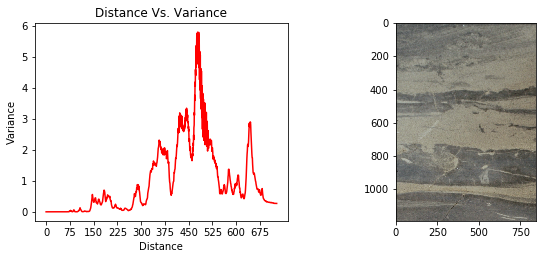

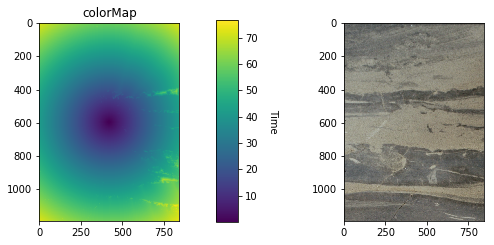

2d
843x1191
2d
843x1191


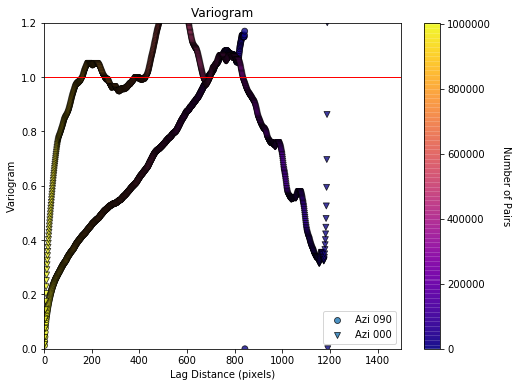

working...Man-2-11805'10_med.jpg


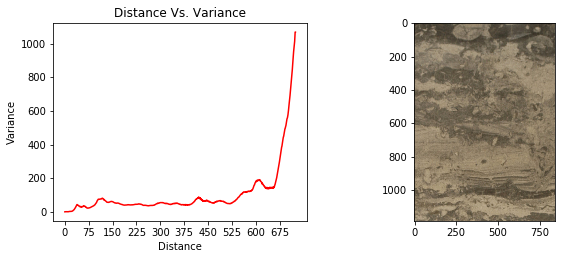

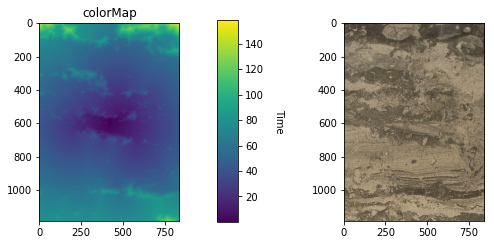

2d
840x1185
2d
840x1185


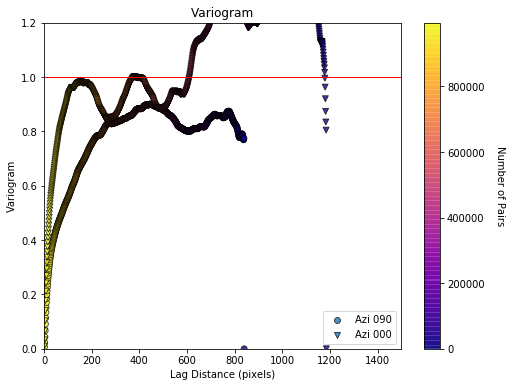

working...Man-2-11809_med.jpg


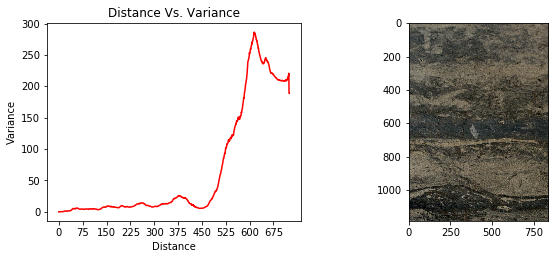

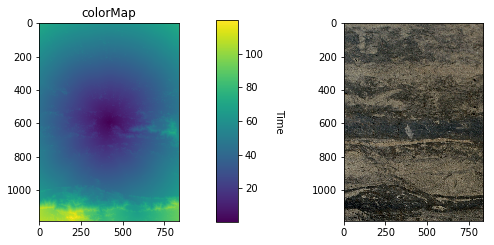

2d
838x1186
2d
838x1186


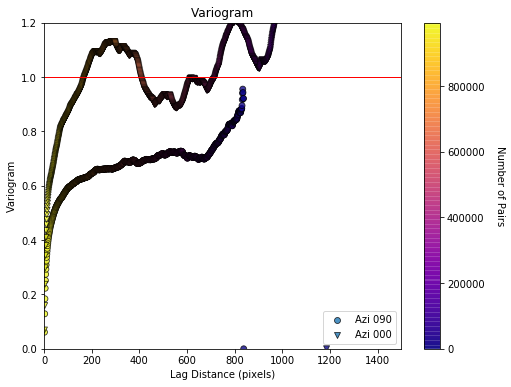

working...Man-2-11818_low.jpg


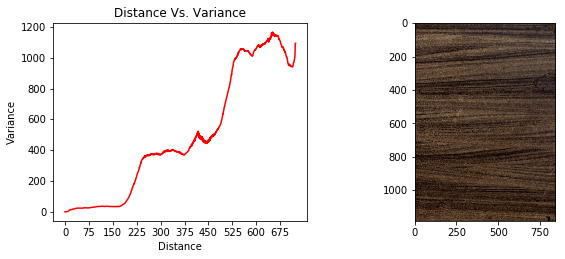

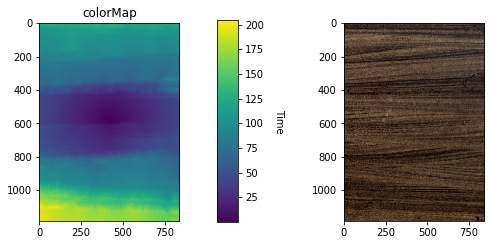

2d
838x1183
2d
838x1183


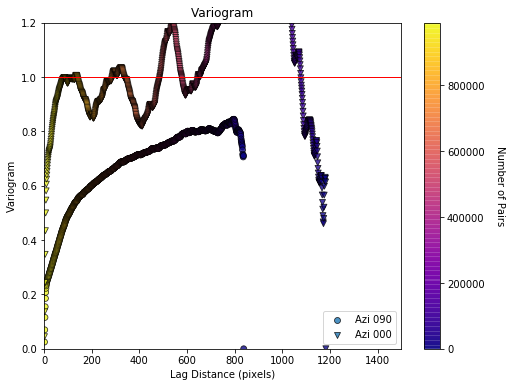

working...Man-2-11833_med.jpg


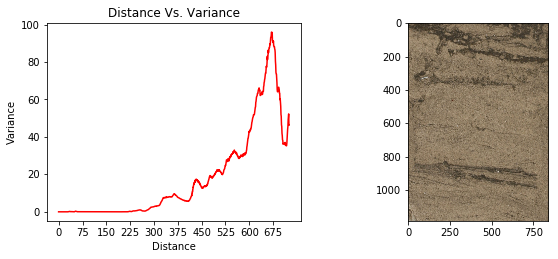

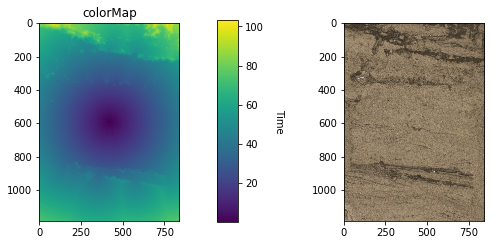

2d
840x1186
2d
840x1186


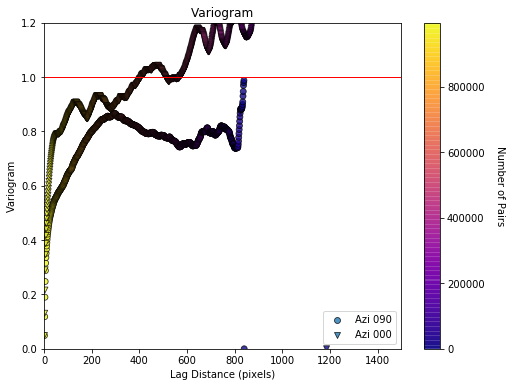

working...Man-2-11834'6_low.jpg


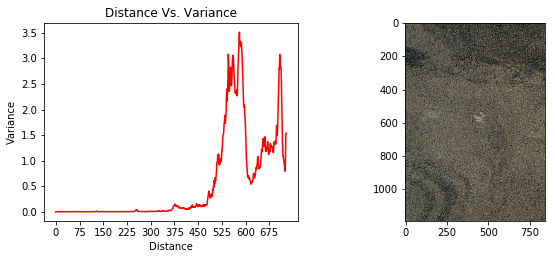

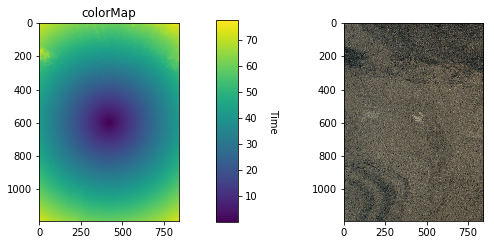

2d
843x1192
2d
843x1192


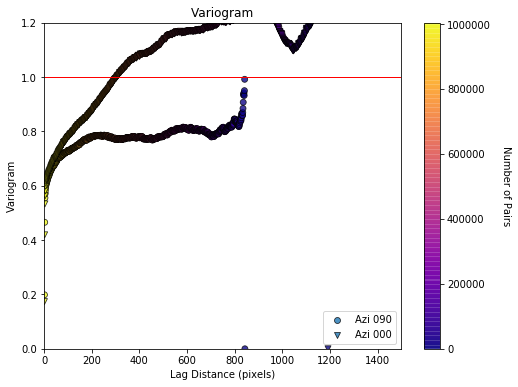

working...man-2-11837_med.jpg


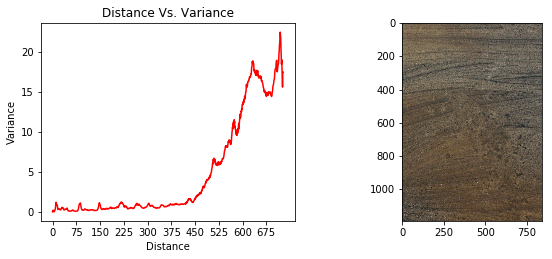

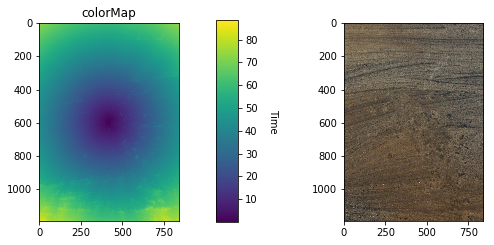

2d
842x1191
2d
842x1191


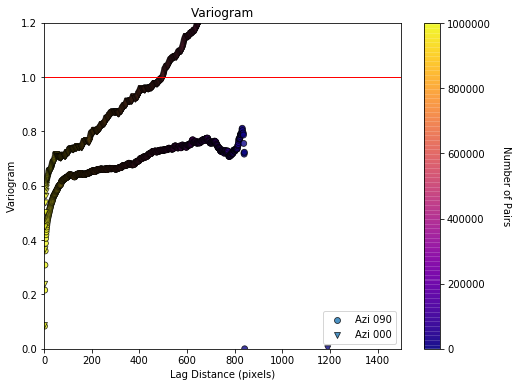

working...Man-2-11874'4_high.jpg


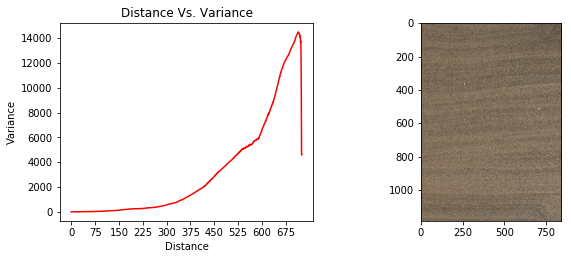

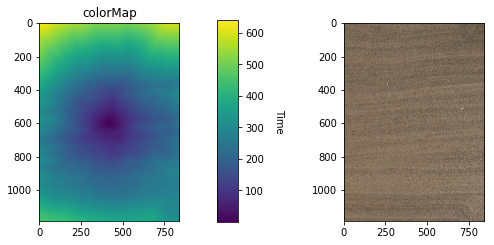

2d
840x1186
2d
840x1186


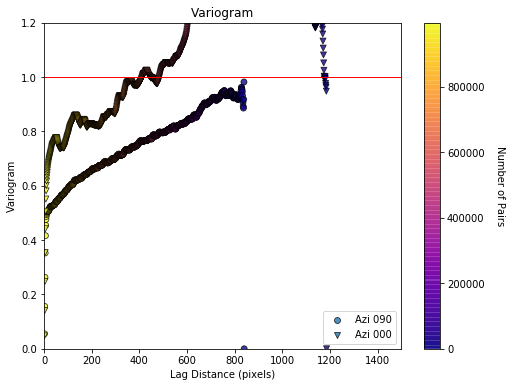

working...man-2-11930'9_high.jpg


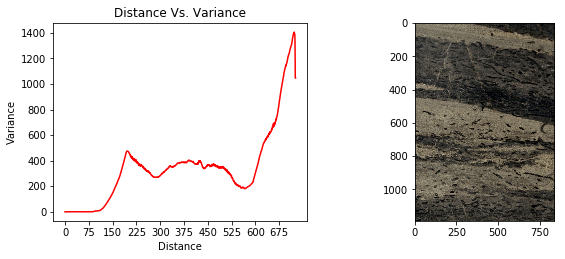

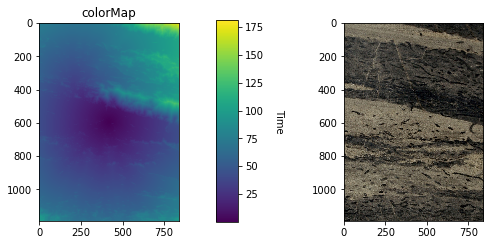

2d
840x1189
2d
840x1189


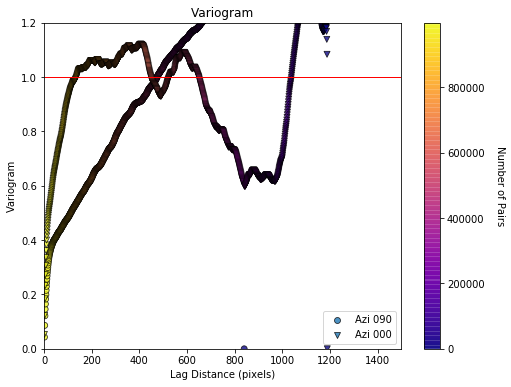

working...Man-2-11937_high.jpg


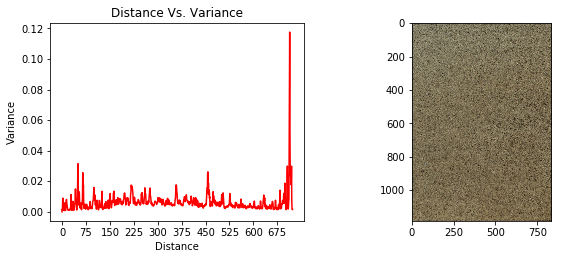

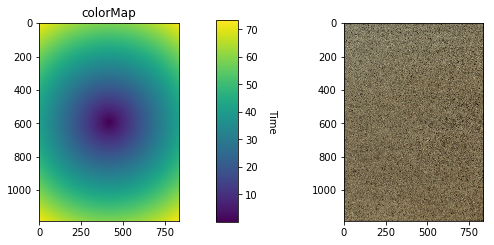

2d
836x1183
2d
836x1183


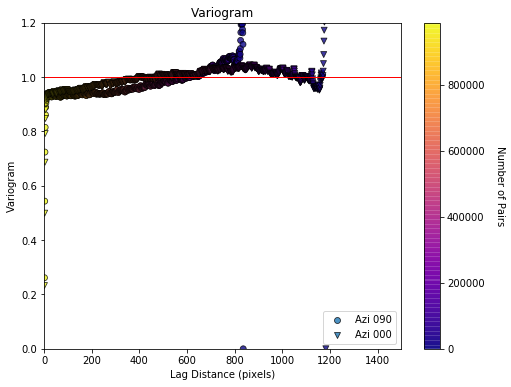

In [8]:
image_convert(r'C:\Users\jonat\Labeled_Crop')

In [67]:
lst, name = get_data()[3], get_data()[4]
words = ['high','med','low']
bio_rank = bio_lvl(words,lst,name)

df_test = multivariate(bio_rank)[0]
df_train = multivariate(bio_rank)[1]







spacer

Level of Bioturbation = Nugget(-0.00341) + Range_x(0.00046) + Range_y(4.35674) + Area(7.2e-07)

R² = 0.6699329896921565
           Unnamed: 0          Area                    Name  Range_x  Range_y  \
Image_num                                                                       
1                   0  1.005827e+03   Man-2-11802'8_low.jpg    690.0    164.0   
2                   1  7.663591e+04  Man-2-11805'10_med.jpg    446.0    377.0   
3                   2  4.698698e+04     Man-2-11809_med.jpg    834.0    170.0   
4                   3  3.896824e+05     Man-2-11818_low.jpg    797.0    131.0   
5                   4  1.404933e+04     Man-2-11833_Med.jpg    839.0    407.0   
6                   5  4.036758e+02   Man-2-11834'6_low.jpg    842.0    306.0   
7                   6  3.455939e+03     man-2-11837_med.jpg    832.0    501.0   
8                   7  2.520746e+06  Man-2-11874'4_high.jpg    839.0    412.0   
9                   8  2.626291e+05  man-2-11930'9_high.jpg   

C:\Users\jonat\Research\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


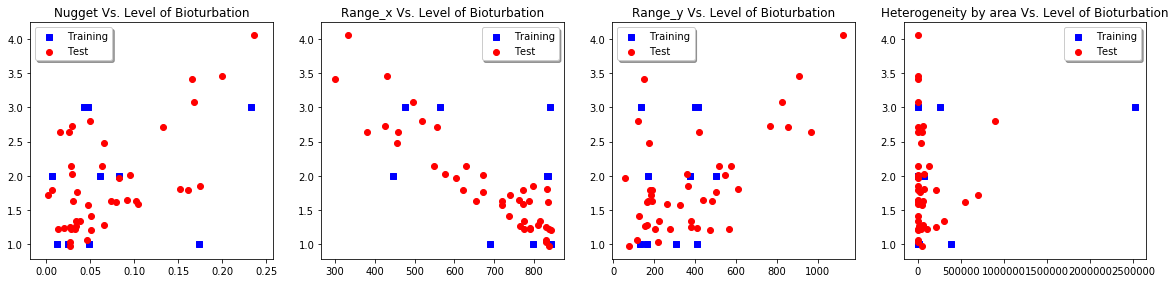

In [70]:
nug_list, range_x, range_y, area,  name = get_data()



words = ['high','med','low']
bio_rank = bio_lvl(words, nug_list, name)

scatter(nug_list,bio_rank, 'nugget',1,1)
scatter(range_x, bio_rank, 'range_x',2,1)
scatter(range_y,bio_rank, 'range_y',3, 1)
scatter(area, bio_rank, 'area', 4, 1)

scatter(df['Nug'],df['Bio_rank'], 'Nugget',1,2)
scatter(df['Range_x'],df['Bio_rank'], 'Range_x',2, 2)
scatter(df['Range_y'],df['Bio_rank'], 'Range_y',3, 2)
scatter(df['Area'], df['Bio_rank'], 'Heterogeneity by area', 4,2)


bins = 30
hxmin = 0
hxmax = 1
hist(z,hxmin, hxmax, bins= bins, weights = None, log = False, cumul = False, 
     xlabel = "Light Weight", title = "Light Density")

In [57]:
df_test.to_csv('Data_Test_Final.csv')
df_train.to_csv('Data_Train_Final.csv')

In [187]:
print(u'H\u2082\u2082')

H₂O₂


In [235]:
names = ['dlkfajdfljlow', 'alkdjfalkdjfhigh', 'akdjf;lakmed']
word = 'low'
if any(word in x for x in names):
    print('hello')

hello


1